In [3]:
import pandas

columns = ['face_x', 'face_y','face_width','face_height','face_cam_x', 'face_cam_y','face_cam_z',
          'torso_x','torso_y','torso_width','torso_height','torso_cam_x','torso_cam_y','torso_cam_z',
          'person_x','person_y','person_width','person_height','person_cam_x','person_cam_y','person_cam_z',
        'mean_cam_z']
df = pandas.read_csv('data.csv')
#df = pandas.DataFrame(data.values, columns=columns)

df.head()

,face_x,face_y,face_width,face_height,face_cam_x,face_cam_y,face_cam_z,torso_x,torso_y,torso_width,...,torso_cam_y,torso_cam_z,person_x,person_y,person_width,person_height,person_cam_x,person_cam_y,person_cam_z,mean_cam_z
0,570.0,156.0,59.0,46.0,3.222619,-0.699850,6.235,-1.0,-1.0,-1.0,...,NaN,NaN,494.0,136.0,342.0,144.0,3.890177,-0.371194,6.124,6.1795
1,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,-1.0,-1.0,-1.0,...,NaN,NaN,359.0,130.0,348.0,190.0,2.626809,-0.200039,6.592,6.5920
2,294.0,116.0,83.0,54.0,0.035208,-0.143189,0.812,-1.0,-1.0,-1.0,...,NaN,NaN,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,0.8120
3,264.0,68.0,111.0,76.0,0.077445,-1.279389,5.282,166.0,143.0,333.0,...,0.319593,8.995,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,7.1385
4,519.0,11.0,156.0,116.0,2.151638,-1.291524,4.192,308.0,107.0,371.0,...,0.264356,6.468,-1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,5.3300


In [11]:
import numpy as np

# preparing data
face_X = df[['face_x',  'face_y', 'face_width', 'face_height']].values
torso_X = df[['torso_x',  'torso_y',  'torso_width',  'torso_height']].values
person_X = df[['person_x', 'person_y', 'person_width', 'person_height']].values

face_y = df['face_cam_z'].values
torso_y = df['torso_cam_z'].values
person_y = df['person_cam_z'].values

X = [face_X, torso_X, person_X]
Y = [face_y, torso_y, person_y]

for i, (x, y) in enumerate(zip(X, Y)):
    keep = ~np.isnan(y)    
    X[i] = x[keep,:]
    Y[i] = y[keep]
    print(X[i].shape, Y[i].shape)


(265, 4) (265,)
(209, 4) (209,)
(207, 4) (207,)


(204,)
(188,)
(155,)


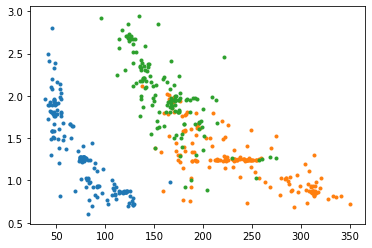

In [50]:
import matplotlib.pyplot as plt

# remove long data
for i, (x, y) in enumerate(zip(X, Y)):
    print(y.shape)
    short_data = y < 3.
    Y[i] = y[short_data]
    X[i] = x[short_data, :]    
    #print(y.shape)

for i in range(3):
    plt.plot(X[i][:,3],Y[i],'.')
plt.show()

In [6]:
from sklearn.model_selection import cross_val_score

# Best possible score is 1.0 and it can be negative 
# (because the model can be arbitrarily worse). 
# A constant model that always predicts the expected value of y, 
# disregarding the input features, would get a R^2 score of 0.0.

def get_scores(X, y, cv, estimator, scoring='r2'):

    return cross_val_score(estimator=estimator, 
                        X=X, 
                        y=y, 
                        cv=cv,
                        scoring=scoring)

In [60]:
#  random forest Regressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

kf = KFold(n_splits=10, shuffle=True)

face_scores_rfr   = get_scores(X[0][:,2:], Y[0], kf, RandomForestRegressor(n_estimators=100) )
torso_scores_rfr  = get_scores(X[1][:,2:], Y[1], kf, RandomForestRegressor(n_estimators=100) )
person_scores_rfr = get_scores(X[2][:,2:], Y[2], kf, RandomForestRegressor(n_estimators=100) )

print('Face: ',   np.mean(face_scores_rfr))
print('Torso: ',  np.mean(torso_scores_rfr))
print('Person: ', np.mean(person_scores_rfr))

Face:  0.7346933636048202
Torso:  0.6153692707430733
Person:  0.4651635198272044


In [62]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

lr = LogisticRegression(C = 0.01, solver = 'lbfgs', penalty='l2', max_iter = 1000)

face_scores_lr   = get_scores(preprocessing.scale(X[0][:,2:]), np.round(1000*Y[0]), kf, lr)
torso_scores_lr  = get_scores(preprocessing.scale(X[1][:,2:]), np.round(1000*Y[1]), kf, lr)
person_scores_lr = get_scores(preprocessing.scale(X[2][:,2:]), np.round(1000*Y[2]), kf, lr)

print('Face: ',   np.mean(face_scores_lr))
print('Torso: ',  np.mean(torso_scores_lr))
print('Person: ', np.mean(person_scores_lr))

Face:  -0.08879203090045133
Torso:  -0.06485321350380543
Person:  -0.3305002568383663


In [70]:
# logistic regression2
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

lr = LogisticRegression(C = 1000, solver = 'lbfgs', penalty='l2', max_iter = 1000)

face_scores_lr   = get_scores(X[0][:,2:] / np.array([620, 480]), np.round(10*Y[0]), kf, lr)
torso_scores_lr  = get_scores(X[1][:,2:] / np.array([620, 480]), np.round(10*Y[1]), kf, lr)
person_scores_lr = get_scores(X[2][:,2:] / np.array([620, 480]), np.round(10*Y[2]), kf, lr)

print('Face: ',   np.mean(face_scores_lr))
print('Torso: ',  np.mean(torso_scores_lr))
print('Person: ', np.mean(person_scores_lr))

Face:  0.7368328822646543
Torso:  0.22880592519887832
Person:  0.4968390442868241


In [78]:
# simple neuronet
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes=(100, 100, 100),tol=1e-2, max_iter=1000)
kf = KFold(n_splits=2, shuffle=True)

face_scores_nn   = get_scores(preprocessing.scale(X[0][:,2:]), Y[0], kf, nn)
torso_scores_nn  = get_scores(preprocessing.scale(X[1][:,2:]), Y[1], kf, nn)
person_scores_nn = get_scores(preprocessing.scale(X[2][:,2:]), Y[2], kf, nn)

print('Face: ',   np.mean(face_scores_nn))
print('Torso: ',  np.mean(torso_scores_nn))
print('Person: ', np.mean(person_scores_nn))

Face:  0.6650972924346097
Torso:  -0.15505068887017376
Person:  0.0013366924691952664
